## Main

Compares training methods, generates graph

### Imports and Setup

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from models import simple_testing_NN

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# Hyperparameters

batch_size = 128
epochs = 10

In [4]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"Number of batches: {len(train_dataloader)}")

Number of batches: 469


### Model

In [5]:
optimizers = [
    torch.optim.SGD,
    torch.optim.Adam,
    torch.optim.RMSprop
]

lrs = [0.01, 0.001, 0.01]

num_opts = len(optimizers)

In [6]:
from copy import deepcopy
model = simple_testing_NN().to(device)
models = [deepcopy(model) for _ in range(num_opts)]

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    history = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            history.append(loss)
    return history

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [10]:
his = [[] for _ in range(num_opts)]
for i in range(num_opts):
    print(f"Using {optimizers[i].__name__}")
    for t in range(epochs):
        print(f"Epoch {t+1}: ")
        
        loss = train(
            train_dataloader,
            models[i],
            loss_fn,
            optimizers[i](models[i].parameters(), lr=lrs[i]))

        his[i].append(loss)
        test(test_dataloader, models[i], loss_fn)

    print("Done!\n")


Using SGD
Epoch 1: 
Test Error: Accuracy: 60.0%, Avg loss: 1.856903
Epoch 2: 
Test Error: Accuracy: 81.9%, Avg loss: 0.772197
Epoch 3: 
Test Error: Accuracy: 86.6%, Avg loss: 0.508226
Epoch 4: 
Test Error: Accuracy: 88.4%, Avg loss: 0.419774
Epoch 5: 
Test Error: Accuracy: 89.2%, Avg loss: 0.376051
Epoch 6: 
Test Error: Accuracy: 89.8%, Avg loss: 0.349440
Epoch 7: 
Test Error: Accuracy: 90.4%, Avg loss: 0.330859
Epoch 8: 
Test Error: Accuracy: 90.7%, Avg loss: 0.316792
Epoch 9: 
Test Error: Accuracy: 91.1%, Avg loss: 0.305423
Epoch 10: 
Test Error: Accuracy: 91.3%, Avg loss: 0.295769
Done!

Using Adam
Epoch 1: 
Test Error: Accuracy: 92.4%, Avg loss: 0.256625
Epoch 2: 
Test Error: Accuracy: 93.9%, Avg loss: 0.194758
Epoch 3: 
Test Error: Accuracy: 95.4%, Avg loss: 0.149978
Epoch 4: 
Test Error: Accuracy: 96.0%, Avg loss: 0.128060
Epoch 5: 
Test Error: Accuracy: 96.7%, Avg loss: 0.110809
Epoch 6: 
Test Error: Accuracy: 96.8%, Avg loss: 0.104223
Epoch 7: 
Test Error: Accuracy: 97.0%, Avg 

In [11]:
for i in range(num_opts):
    his[i] = torch.tensor(his[i]).reshape(-1)

### Plotting Results

In [12]:
from matplotlib import pyplot as plt

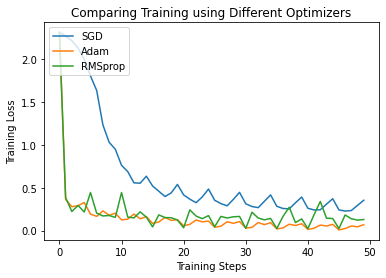

In [13]:
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Comparing Training using Different Optimizers')
for i in range(num_opts):
    plt.plot(his[i], label=optimizers[i].__name__)

plt.legend(loc="upper left")
plt.show()